<a href="https://colab.research.google.com/github/kalkan/python-ile-mekansal-raster-isleme-atolyesi/blob/main/Mekansal_Raster_Atolyesi_Say%C4%B1sal_Y%C3%BCkseklik_Modeli_Github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python ile Mekansal Raster İşleme Atölyesi


https://github.com/kalkan/python-ile-mekansal-raster-isleme-atolyesi/blob/main/README.md

Bu atölyede SRTM yükseklik verisi okunarak, bir bölge için kesilecek ve zonal istatistikler hesaplanacaktır.

In [1]:
# gerekli yüklemeler 
!pip install contextily
!pip install rasterio
!pip install geopandas
!pip install rasterstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 KB 2.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 KB 13.6 MB/s eta 0:00:00
  Attempting uninstall: fiona
    Found ex

In [2]:
# kullanacağımız fonksiyonları içeri alalım
import os
import contextily as cx
import rasterio
from rasterio.plot import show as rioshow
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterstats
import pandas

https://search.earthdata.nasa.gov/search/granules?p=C1546314043-LPDAAC_ECS  adresinden NASADEM Merged DEM Global 1 arc second V001 veri seti araması ile sağ taraftan indireceğimiz bölgenin alanını kare içine alarak arama yapıyoruz ve ilgili bölgenin .zip uzantılı .hgt yükseklik veri setini indiriyoruz. 

In [3]:
# verilerim google drive'da olduğundan drive ile colab'ı bağlıyorum.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# colab'de verilerimin olduğu klasörü bağlıyorum.
os.chdir('/content/drive/MyDrive/_tubitak/liderlik/2022/08.2022/mekansal-raster')

İndirdiğimiz bölgeye ait ilçe sınırlarını vektör veri formatında https://gadm.org/ sitesinden indiriyoruz. Level-2 olan veri ilçeleri içermektedir. GeoJSON formatında Level-2 veri bu çalışmada yeterli olacaktır. 

Level-2 Türkiye GeoJSON Verisi: 
https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_TUR_2.json.zip

<AxesSubplot:>

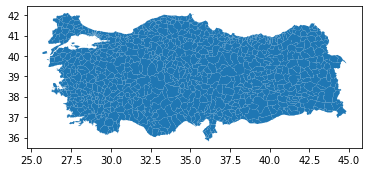

In [6]:
# read turkey level-2 geojson
ilceler = gpd.read_file('gadm41_TUR_2.json')
ilceler.plot()

In [8]:
ilceler.head()

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,TUR.1.1_1,TUR,Turkey,TUR.1_1,Adana,NA,Aladağ,NA,NA,District,District,NA,TR.AA.AL,"MULTIPOLYGON (((35.58970 37.94590, 35.56940 37..."
1,TUR.1.2_1,TUR,Turkey,TUR.1_1,Adana,NA,Ceyhan,NA,NA,District,District,NA,TR.AA.CE,"MULTIPOLYGON (((35.93400 36.87990, 35.92240 36..."
2,TUR.1.3_1,TUR,Turkey,TUR.1_1,Adana,NA,Feke,NA,NA,District,District,NA,TR.AA.FE,"MULTIPOLYGON (((35.64170 37.70990, 35.62810 37..."
3,TUR.1.4_1,TUR,Turkey,TUR.1_1,Adana,NA,İmamoğlu,NA,NA,District,District,NA,TR.AA.IM,"MULTIPOLYGON (((35.43950 37.30670, 35.45380 37..."
4,TUR.1.5_1,TUR,Turkey,TUR.1_1,Adana,NA,Karaisali,NA,NA,District,District,NA,TR.AA.KS,"MULTIPOLYGON (((35.09230 37.49990, 35.12020 37..."


In [9]:
secileniller = ilceler[(ilceler['NAME_1'] == 'Istanbul') | (ilceler['NAME_1'] == 'Bursa') | (ilceler['NAME_1'] == 'Kocaeli')]

In [10]:
bursailceler = ilceler[(ilceler['NAME_2'] == 'Karamürsel') | (ilceler['NAME_2'] == 'Orhangazi') | (ilceler['NAME_2'] == 'İznik')]

In [ ]:
bursailceler

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
212,TUR.21.6_1,TUR,Turkey,TUR.21_1,Bursa,NA,İznik,NA,NA,District,District,NA,TR.BU.IZ,"MULTIPOLYGON (((29.94150 40.53150, 29.92470 40..."
220,TUR.21.14_1,TUR,Turkey,TUR.21_1,Bursa,NA,Orhangazi,NA,NA,District,District,NA,TR.BU.OG,"MULTIPOLYGON (((29.32540 40.36900, 29.30510 40..."
593,TUR.52.5_1,TUR,Turkey,TUR.52_1,Kocaeli,NA,Karamürsel,NA,NA,District,District,NA,TR.KC.KM,"MULTIPOLYGON (((29.70730 40.59710, 29.67250 40..."


In [11]:
bursailceler['NAME_2']

212         İznik
220     Orhangazi
593    Karamürsel
Name: NAME_2, dtype: object

<AxesSubplot:>

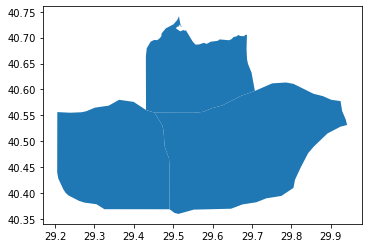

In [12]:
bursailceler.plot()

<AxesSubplot:>

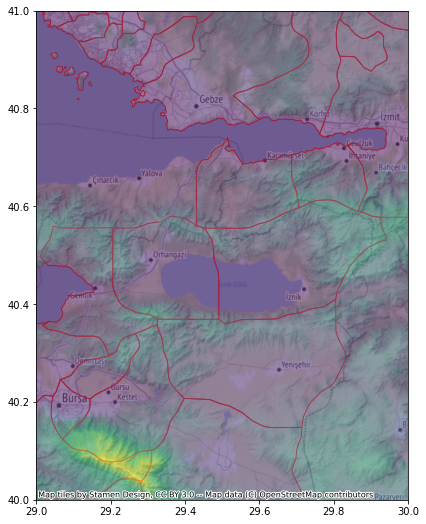

In [13]:
r = rasterio.open("n40e029.hgt")

f, ax = plt.subplots(1, figsize=(9, 9))
ax = rioshow(r, alpha=0.5, zorder=2, ax=ax)
cx.add_basemap(ax, crs=r.crs) 
secileniller.plot(facecolor="none", edgecolor="#F93822", zorder=1, ax=ax)

<AxesSubplot:>

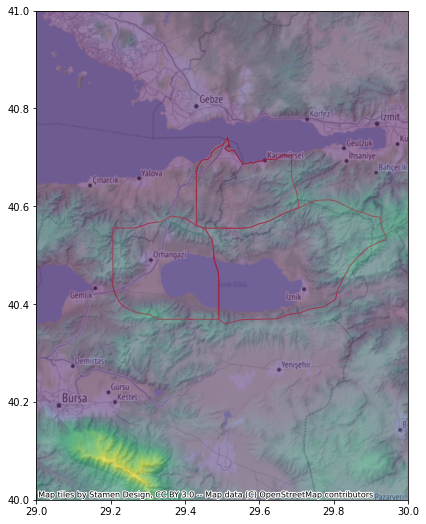

In [14]:
r = rasterio.open("n40e029.hgt")

f, ax = plt.subplots(1, figsize=(9, 9))
ax = rioshow(r, alpha=0.5, zorder=2, ax=ax)
cx.add_basemap(ax, crs=r.crs) 
bursailceler.plot(facecolor="none", edgecolor="#F93822", zorder=1, ax=ax)

In [15]:
from rasterstats import zonal_stats

elevations2 = zonal_stats(bursailceler, 'n40e029.hgt',  stats="count min mean max median")
elevations2 = pandas.DataFrame(elevations2)

In [16]:
elevations2

,min,max,mean,count,median
0,80.0,1252.0,405.314827,1012828,344.0
1,39.0,1277.0,294.250471,668939,174.0
2,-6.0,1104.0,277.347864,467430,236.0


In [17]:
bursailceler.to_file("bursa.geojson", driver="GeoJSON")

In [21]:
! rio mask n40e029.hgt \
           bursa.tif \
           --crop \
           --geojson-mask\
           bursa.geojson


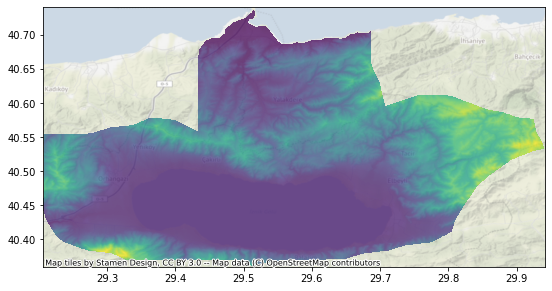

In [22]:
f, ax = plt.subplots(1, figsize=(9, 9))
r = rasterio.open("bursa.tif")
rioshow(r, zorder=1, alpha=0.75, ax=ax)
cx.add_basemap(ax, alpha=0.5, crs=r.crs)